# Lab 2: Spatial Filtering

For 18-793 Image and Video Processing course. By Sarun Gulyanon.

This Jupyter Notebook demonstrates basic spatial filtering operations on images using OpenCV and NumPy. We will cover:

**Lowpass filters**

  1. Box Filter  
  2. Gaussian Filter  
  3. Median Filter

**Highpass filters**

  4. Sharpening with the Laplacian  
  5. Sharpening with Derivative

## Import necessary libraries

We will use OpenCV for image processing, NumPy for numerical operations, and Matplotlib for displaying images.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

If you use colab, run this command to download the example image.

In [2]:
# !mkdir img
# !wget https://github.com/sgulyano/imgvdoproc/raw/refs/heads/main/img/moon.tif -O img/moon.tif

Read sample image.

In [3]:
image_path = "img/moon.tif"  # Replace with an actual image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

Add an auxiliary function to show image results.

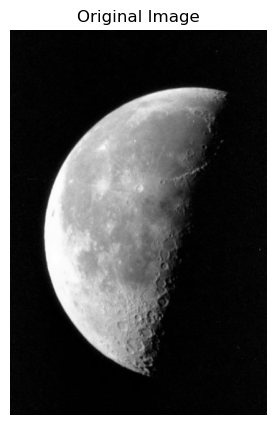

In [12]:
# Function to display images inline using matplotlib
def show_image(title=["Image"], *img):
    plt.figure(figsize=(5*len(img), 5))
    for i in range(len(img)):
        plt.subplot(1, len(img), i+1)
        plt.imshow(img[i], cmap='gray')
        plt.title(title[i])
        plt.axis('off')
    plt.show()

show_image(["Original Image"], image)

### Add Random Noise (Gaussian) 

We create normally distributed noise and add it to the original image. Gaussian-distributed noise is a common model for natural variations in images, reflecting many real-world processes that sum up to a normally distributed pattern of fluctuations. This is also called *"Additive White Gaussian Noise" (AWGN)"*.

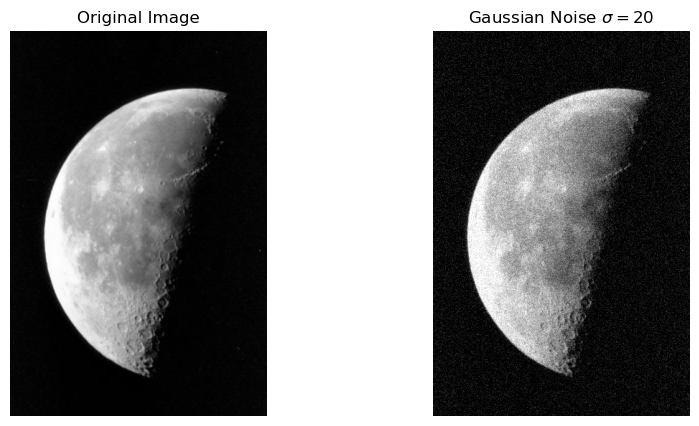

In [5]:
def add_gaussian_noise(img, mean=0, std=20):
    noisy = img.astype(np.float32)
    gauss = np.random.normal(mean, std, img.shape)
    noisy += gauss
    # Clip to valid range and convert back to uint8
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

std = 20
gaussian_noisy_image = add_gaussian_noise(image, 0, std)
show_image(["Original Image", f"Gaussian Noise $\sigma={std}$"], image, gaussian_noisy_image)

> ### Exercise
> Try lowpass filters on Gaussian noisy image with different values of standard deviation (STD). What effects do you observe?
> Should we try different values of mean as well? What do you think?

### Add Salt-and-Pepper Noise

Salt-and-pepper noise: We randomly set a certain percentage of pixels to 0 or 255.

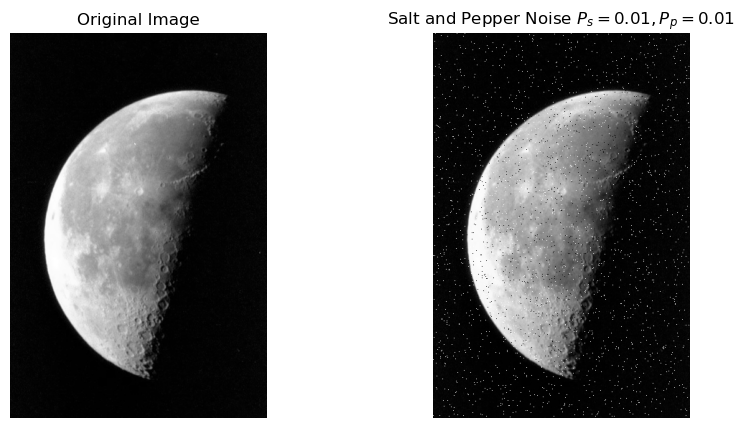

In [6]:
def add_salt_pepper_noise(img, amount=0.02, salt_ratio=0.5):
    noisy = img.copy()
    num_salt = int(amount * img.size * salt_ratio)
    num_pepper = int(amount * img.size * (1.0 - salt_ratio))

    # Salt noise
    coords = [np.random.randint(0, i - 1, num_salt) for i in img.shape]
    noisy[coords[0], coords[1]] = 255

    # Pepper noise
    coords = [np.random.randint(0, i - 1, num_pepper) for i in img.shape]
    noisy[coords[0], coords[1]] = 0

    return noisy

ps = 0.01
pp = 0.01
sp_noisy_image = add_salt_pepper_noise(image, amount=ps+pp, salt_ratio=ps/(ps+pp))
show_image(["Original Image", f"Salt and Pepper Noise $P_s={ps}, P_p={pp}$"], image, sp_noisy_image)

> ### Exercise
> Try lowpass filters on salt-and-pepper noisy image with different amount (the sum of salt and pepper; try between 0.02-0.2 ) and different salt ratio (try between 0.0-1.0). What effects do you observe?

## 1. Box Filter

A box filter (or mean filter) applies a kernel of uniform weights.
The function `cv2.blur` applies this average-smoothing operation over a given kernel size.
Larger kernel sizes result in stronger smoothing.

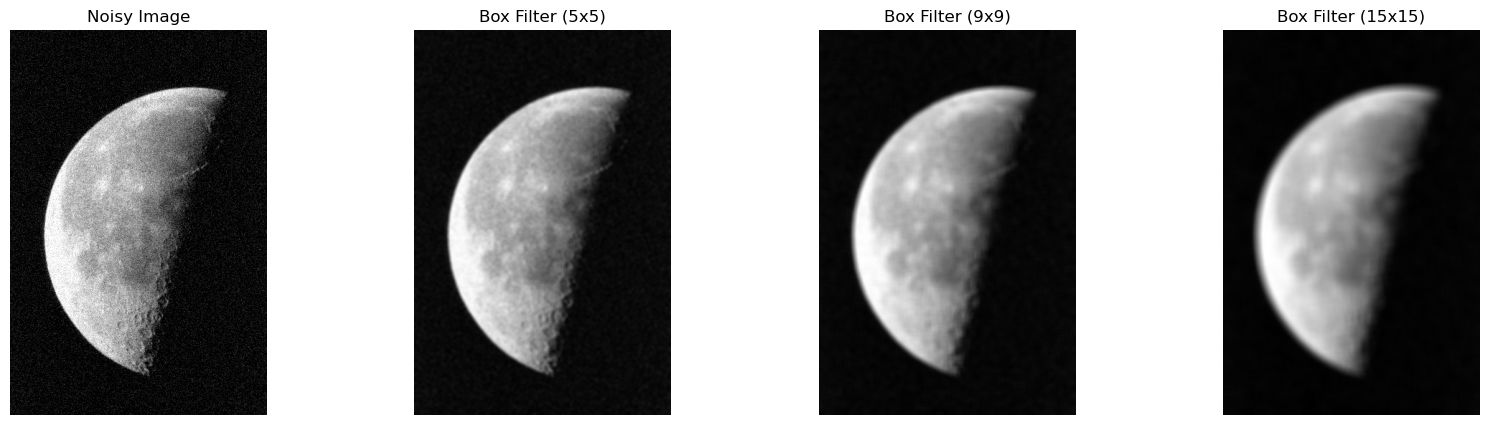

In [7]:
# Use Box filter (mean filter) using cv2.blur with different kernel sizes
box_filtered = []
titles = []
for ks in [5, 9, 15]:
    box_filtered.append(cv2.blur(gaussian_noisy_image, (ks, ks)))
    titles.append(f"Box Filter ({ks}x{ks})")

show_image(['Noisy Image'] + titles, gaussian_noisy_image, *box_filtered)

## 2. Gaussian Filter

The Gaussian filter applies a Gaussian kernel, which assigns higher weights near the center of the kernel.
The function `cv2.GaussianBlur` applies the Gaussian blur with the given kernel size and standard deviation.
This filter is commonly used for noise reduction with less blurring compared to a box filter.

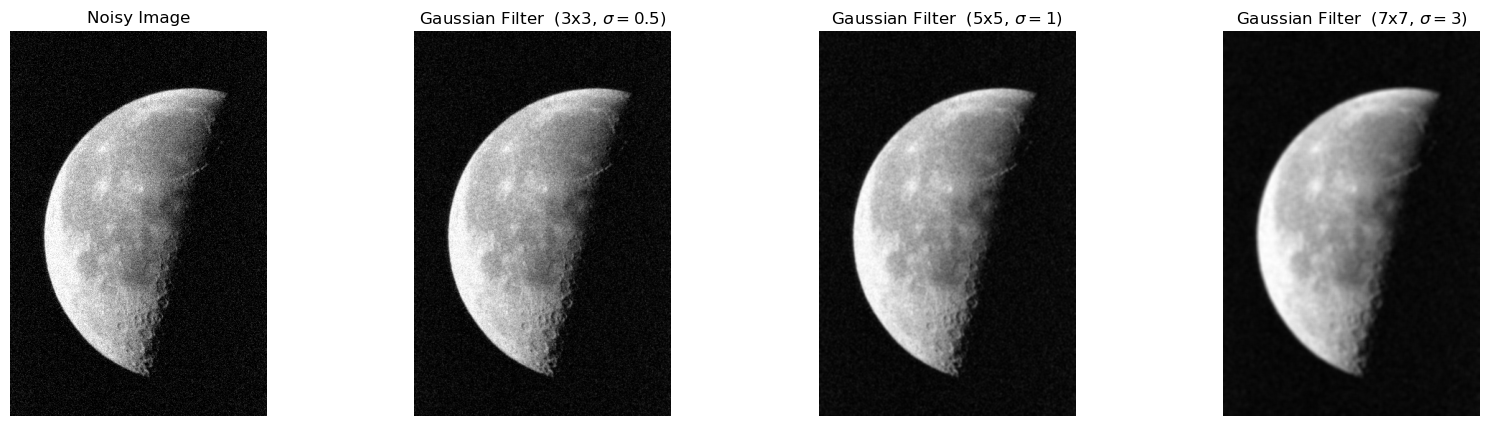

In [8]:
# Use Gaussian filter using cv2.GaussianBlur with different kernal size and standard deviation.
gaussian_filtered = []
titles = []
for ks, std in zip([3, 5, 7], [0.5, 1, 3]):
    gaussian_filtered.append(cv2.GaussianBlur(gaussian_noisy_image, (ks, ks), std))
    titles.append(f"Gaussian Filter  ({ks}x{ks}, $\sigma={std}$)")

show_image(['Noisy Image'] + titles, gaussian_noisy_image, *gaussian_filtered)

## 3. Median Filter

The median filter replaces each pixel with the median of the intensities in its neighborhood.
This is very effective at removing certain types of salt-and-pepper noise.
We use `cv2.medianBlur`, specifying the aperture size (kernel size).


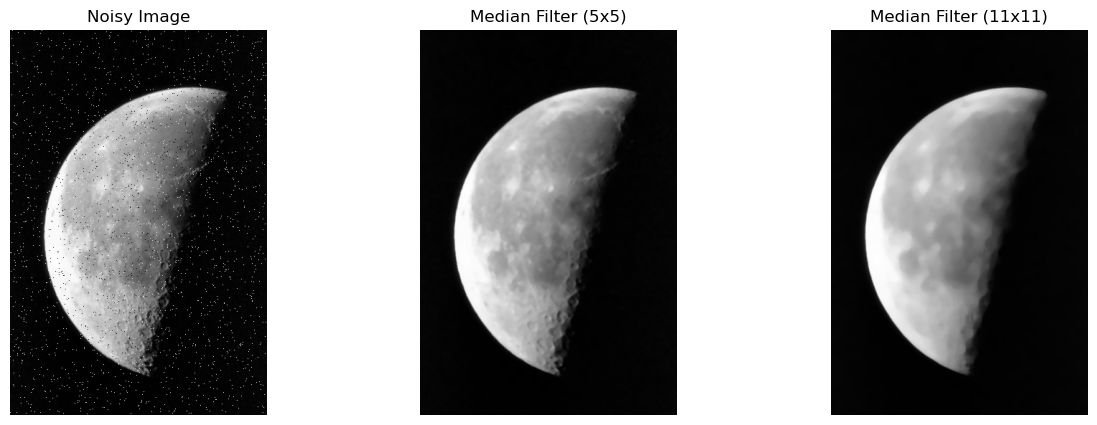

In [9]:
# Median filter using cv2.medianBlur with different kernel size.
median_filtered = []
titles = []
for ks in [5, 11]:
    median_filtered.append(cv2.medianBlur(sp_noisy_image, ks))
    titles.append(f"Median Filter ({ks}x{ks})")

show_image(['Noisy Image'] + titles, sp_noisy_image, *median_filtered)

## 4. Sharpening with the Laplacian

The Laplacian operator highlights regions of rapid intensity change (edges).
After computing the Laplacian, we convert it to a suitable display range (using convertScaleAbs).
We then add the scaled Laplacian back to the original image to enhance edges and create a sharpening effect.

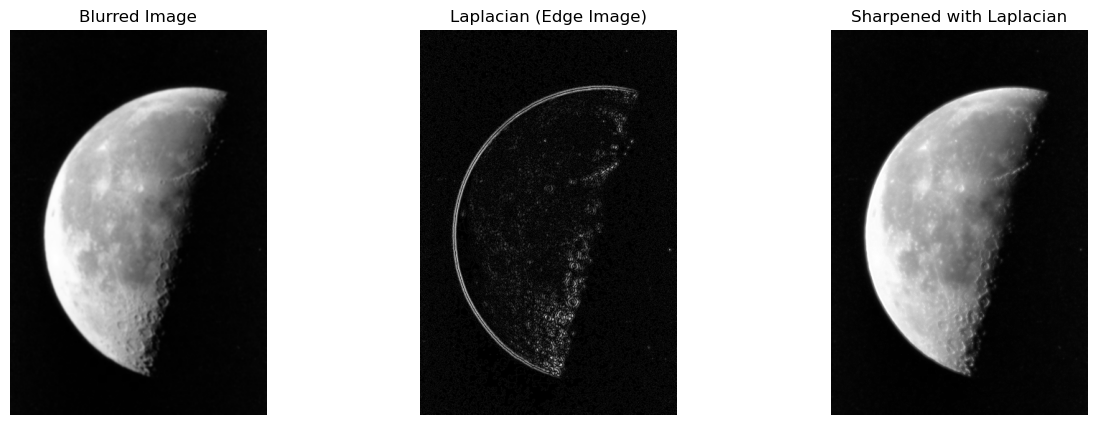

In [10]:
# Given a blurred image that needs to be sharpened.
blur_image = cv2.GaussianBlur(image, (5, 5), 1)

# Apply a Laplacian filter for edges
laplacian = cv2.Laplacian(blur_image, cv2.CV_64F)

# Convert back to uint8
laplacian = cv2.convertScaleAbs(laplacian)

# Sharpen by adding Laplacian to original
sharpened_laplacian = cv2.addWeighted(blur_image, 1, laplacian, 1, 0)

# Display
show_image(["Blurred Image", "Laplacian (Edge Image)", "Sharpened with Laplacian"], blur_image, laplacian, sharpened_laplacian)

## 5. Sharpening with Derivative (Sobel)

Sobel operators compute derivatives in the x and y directions, capturing edges.
We calculate the gradient magnitude by combining the Sobel outputs.
Adding this magnitude back to the original image produces a derivative-based sharpening effect.

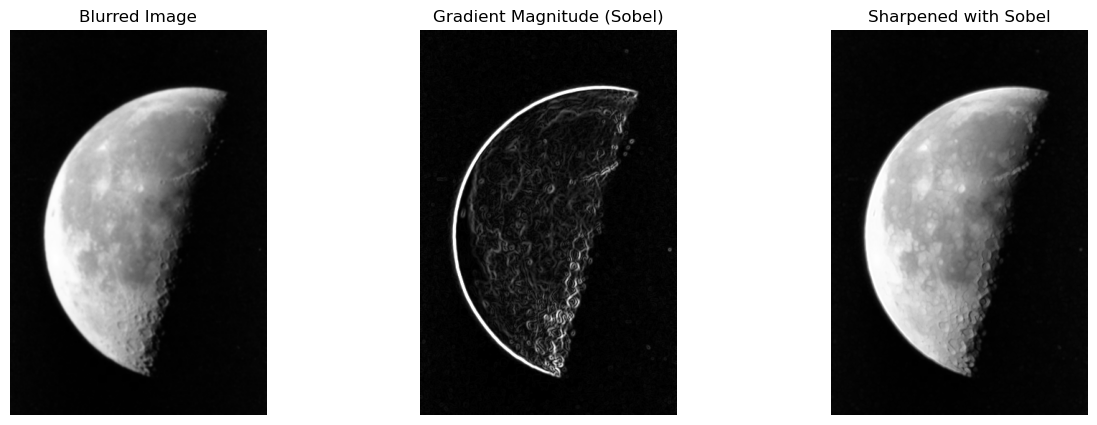

In [11]:
# Given a blurred image that needs to be sharpened.
blur_image = cv2.GaussianBlur(image, (5, 5), 1)

# Use Sobel derivatives to enhance edges
# Compute gradients in x and y directions
sobel_x = cv2.Sobel(blur_image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(blur_image, cv2.CV_64F, 0, 1, ksize=3)

# Combine the gradient magnitudes
magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
magnitude = cv2.convertScaleAbs(magnitude)

# Sharpen by adding gradient to the original
sharpened_sobel = cv2.addWeighted(blur_image, 1, magnitude, 0.2, 0)

# Display
show_image(["Blurred Image", "Gradient Magnitude (Sobel)", "Sharpened with Sobel"], blur_image, magnitude, sharpened_sobel)

## Conclusion

In this tutorial, we demonstrated common spatial filtering techniques:
- **Box filter** for basic averaging  
- **Gaussian filter** for smoother blurring while preserving edges more effectively than a box filter  
- **Median filter** for removing salt-and-pepper noise  
- **Sharpening with the Laplacian** by adding the Laplacian response back to the original image  
- **Sharpening with derivative** using Sobel gradients

These methods form the core of many image processing pipelines where denoising or sharpening is required.

----